In [2]:
# Importações necessárias

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
import joblib


In [3]:
# Carregar os dados

df = pd.read_csv("Obesity.csv")
df.head()


,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
# Tratamento inicial dos dados
    # Arredondar variáveis que vêm com ruído decimal
    
cols_round = ["FCVC", "NCP", "CH2O", "FAF", "TUE"]

for col in cols_round:
    df[col] = df[col].round().astype(int)


In [5]:
# Feature do IMC

df["BMI"] = df["Weight"] / (df["Height"] ** 2)

In [6]:
# Separação entre feature e targets

X = df.drop("Obesity", axis=1)
y = df["Obesity"]

In [7]:
# Variavel alvo

label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)


In [8]:
# Definição das variaveis 

# Númericas

numeric_features = [
    "Age", "Height", "Weight",
    "FCVC", "NCP", "CH2O",
    "FAF", "TUE", "BMI"
]

# Categóricas

categorical_features = [
    "Gender", "family_history", "FAVC", "CAEC",
    "SMOKE", "SCC", "CALC", "MTRANS"
]


In [9]:
# Pré-processamento (Pipeline)

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [10]:
# Modelo: Random Forest

# Por que Random Forest?
# - Lida bem com dados mistos
# - Ótima performance
# - Fácil de explicar para médicos
# - Gera feature importance

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)


In [11]:
# Pipeline Final (Pré-processamento + Modelo)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])


In [12]:
# Split Treino / Teste

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)


In [13]:
# Treinamento do modelo

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE', 'BMI']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'family_history',
                                                   'FAVC', 'CAEC', 'SMOKE',
                                                   'SCC', 'CALC',
                                                   'MTRANS'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

In [14]:
# Avaliação do modelo

y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder_y.classes_))


Accuracy: 0.9739952718676123

Relatório de Classificação:

                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.98      0.99        54
      Normal_Weight       0.89      0.97      0.93        58
     Obesity_Type_I       0.99      1.00      0.99        70
    Obesity_Type_II       0.98      0.98      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.96      0.91      0.94        58
Overweight_Level_II       1.00      0.98      0.99        58

           accuracy                           0.97       423
          macro avg       0.97      0.97      0.97       423
       weighted avg       0.98      0.97      0.97       423



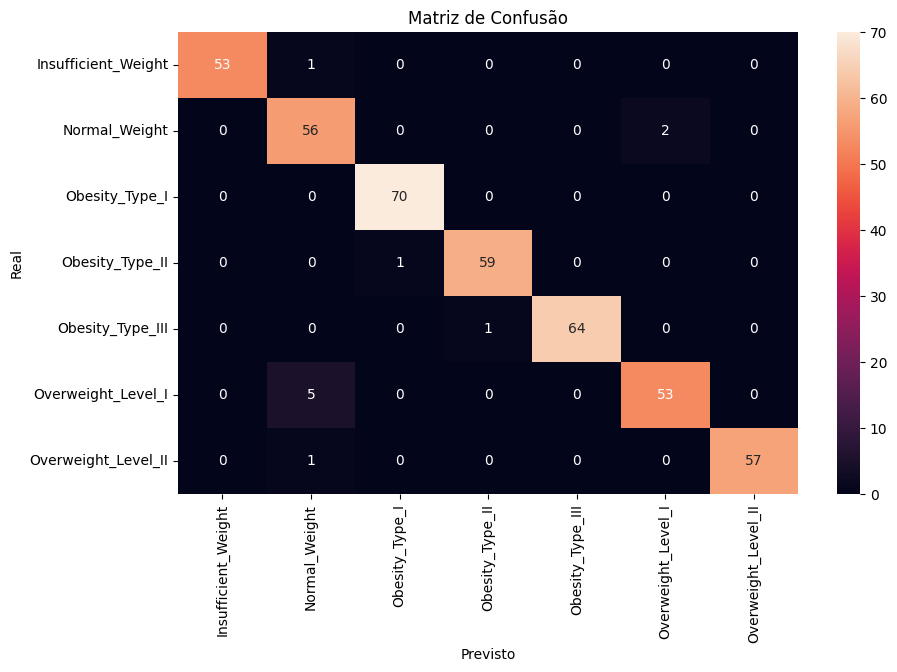

In [15]:
# Matriz de confusão

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=label_encoder_y.classes_,
            yticklabels=label_encoder_y.classes_)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()


In [16]:
joblib.dump(pipeline, "modelo_obesidade.pkl")
joblib.dump(label_encoder_y, "encoder_target.pkl")


['encoder_target.pkl']

In [18]:
# MODELO COMPORTAMENTAL (SEM peso, altura e IMC)

# Novas features

numeric_features_sem_peso = [
    "Age", "FCVC", "NCP", "CH2O", "FAF", "TUE"
]

categorical_features_sem_peso = [
    "Gender", "family_history", "FAVC", "CAEC",
    "SMOKE", "SCC", "CALC", "MTRANS"
]


In [19]:
# Novo pré - processador

numeric_transformer_sem_peso = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer_sem_peso = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_sem_peso = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_sem_peso, numeric_features_sem_peso),
        ("cat", categorical_transformer_sem_peso, categorical_features_sem_peso)
    ]
)


In [20]:
# Novo pepiline 

pipeline_sem_peso = Pipeline(steps=[
    ("preprocessor", preprocessor_sem_peso),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])


In [21]:
# Treinamento 

X_sem_peso = df.drop(
    ["Obesity", "Weight", "Height", "BMI"],
    axis=1
)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_sem_peso,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

pipeline_sem_peso.fit(X_train2, y_train2)

y_pred2 = pipeline_sem_peso.predict(X_test2)

print("Accuracy (modelo comportamental):",
      accuracy_score(y_test2, y_pred2))


Accuracy (modelo comportamental): 0.806146572104019


In [23]:
# Modelo 1 — Clínico (com peso, altura e IMC)

import joblib

joblib.dump(pipeline, "modelo_clinico.pkl")
joblib.dump(label_encoder_y, "encoder_target.pkl")


['encoder_target.pkl']

In [24]:
# Modelo 2 - Comportamental (preventivo)
joblib.dump(pipeline_sem_peso, "modelo_preventivo.pkl")


['modelo_preventivo.pkl']